In [1]:
from bg_atlasapi import BrainGlobeAtlas
from preprocessing_sequencing import preprocess_sequences as ps
from znamutils import slurm_it
import pandas as pd
from final_processing import final_processing_functions as fpf
import numpy as np
import nrrd
import pathlib
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.colors as colors
from sklearn.preprocessing import normalize
import ast
import seaborn as sb
import pickle
import warnings
from scipy import stats
from matplotlib.patches import Rectangle
import scipy
from scipy.stats import binomtest
warnings.filterwarnings('ignore')
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity
%matplotlib inline

First generate area assignments and shuffle

In [2]:
#lets load the datasets for each mouse
mcc = MouseConnectivityCache()
structure_tree = mcc.get_structure_tree()
mice = ['FIAA45.6a', 'FIAA45.6d', 'FIAA55.4d']
cond_prob_dict = {}
area_is_main_dict = {}
homog_across_cubelet_dict = {}
binary_homog_across_cubelet_dict = {}
for mouse in mice:
    mini_dict={}
    binary_mini_dict = {}
    parameters_path = (
    f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/Sequencing")
    barcodes = pd.read_pickle(f"{parameters_path}/A1_barcodes_thresholded.pkl")
    area_is_main_dict[mouse] = fpf.area_is_main(parameters_path=parameters_path, barcode_matrix = barcodes, cortical=True, shuffled=False, IT_only=True)
    mini_dict['actual']=fpf.homog_across_cubelet(parameters_path=parameters_path, barcode_matrix = barcodes, cortical=True, shuffled=False, IT_only=True, binary=False)
    mini_dict['shuffled']=fpf.homog_across_cubelet(parameters_path=parameters_path, barcode_matrix = barcodes, cortical=True, shuffled=True, IT_only=True, binary=False)
    binary_mini_dict['actual_binary'] = fpf.homog_across_cubelet(parameters_path=parameters_path, barcode_matrix = barcodes, cortical=True, shuffled=False, IT_only=True, binary=True)
    binary_mini_dict['shuffled_binary'] = fpf.homog_across_cubelet(parameters_path=parameters_path, barcode_matrix = barcodes, cortical=True, shuffled=True, IT_only=True, binary=True)
    homog_across_cubelet_dict[mouse] = mini_dict
    binary_homog_across_cubelet_dict[mouse] = binary_mini_dict
   

Next, lets compare frequency of observed versus shuffled motifs

In [3]:
common_cols = set(binary_homog_across_cubelet_dict['FIAA45.6a']['actual_binary'].columns).intersection(
    set(binary_homog_across_cubelet_dict['FIAA45.6d']['actual_binary'].columns)
).intersection(
    set(binary_homog_across_cubelet_dict['FIAA55.4d']['actual_binary'].columns)
)

In [4]:
key = 'homogenous_across_cubelet'
all_combined={}
common_cols_cortex = []
for col in common_cols:
    if col not in ['Contra', 'OB']:
        structure = structure_tree.get_structures_by_acronym([col])
        if 315 in structure[0]['structure_id_path']:
            common_cols_cortex.append(col)
combined_matrix = pd.concat([binary_homog_across_cubelet_dict['FIAA45.6a']['actual_binary'][common_cols_cortex], binary_homog_across_cubelet_dict['FIAA45.6d']['actual_binary'][common_cols_cortex], binary_homog_across_cubelet_dict['FIAA55.4d']['actual_binary'][common_cols_cortex]])
cols = ['VISal', 'VISl',  'VISli','VISpor', 'VISpl', 'VISp', 'VISam', 'VISa', 'VISpm', 'VISrl']
#cols = ['VISli','VISpor', 'VISpl', 'VISl', 'VISp', 'VISal', 'VISam', 'VISpm', 'VISa', 'VISrl']
all_combined[key] = combined_matrix
all_combined['shuff_cubelet'] = pd.concat([binary_homog_across_cubelet_dict['FIAA45.6a']['shuffled_binary'][common_cols_cortex], binary_homog_across_cubelet_dict['FIAA45.6d']['shuffled_binary'][common_cols_cortex], binary_homog_across_cubelet_dict['FIAA55.4d']['shuffled_binary'][common_cols_cortex]])

In [8]:
dict_of_co_proj_motifs = {}
for key in all_combined.keys():
    co_proj_motif_actual = pd.DataFrame(columns=cols, index=cols)
    co_proj_motif_joint = pd.DataFrame(columns=cols, index=cols)
    barcodes = all_combined[key].copy()
    for col in common_cols_cortex:
        for col_2 in common_cols_cortex:
            if col == col_2:
                co_proj_motif_actual.loc[col, col_2] = np.nan
                co_proj_motif_joint.loc[col, col_2] = np.nan
            else:
                prob_df = pd.DataFrame()
                prob_df["a"] = barcodes[col].astype(bool)
                prob_df["b"] = barcodes[col_2].astype(bool)
                prob_df["matching"] = prob_df.apply(lambda x: 1 if x['a'] and x['b'] else 0, axis=1)
                probs_actual = prob_df["matching"].sum() / len(barcodes)
                probs_joint = (prob_df["a"].sum() / len(barcodes)) * (prob_df["b"].sum() / len(barcodes))
                co_proj_motif_actual.loc[col, col_2] = probs_actual
                co_proj_motif_joint.loc[col, col_2] = probs_joint
    dict_of_co_proj_motifs[key] = co_proj_motif_actual
    dict_of_co_proj_motifs[f'{key}_joint'] = co_proj_motif_joint



Text(0.5, 0.98, 'log2(actual/joint probability) curveball shuffle')

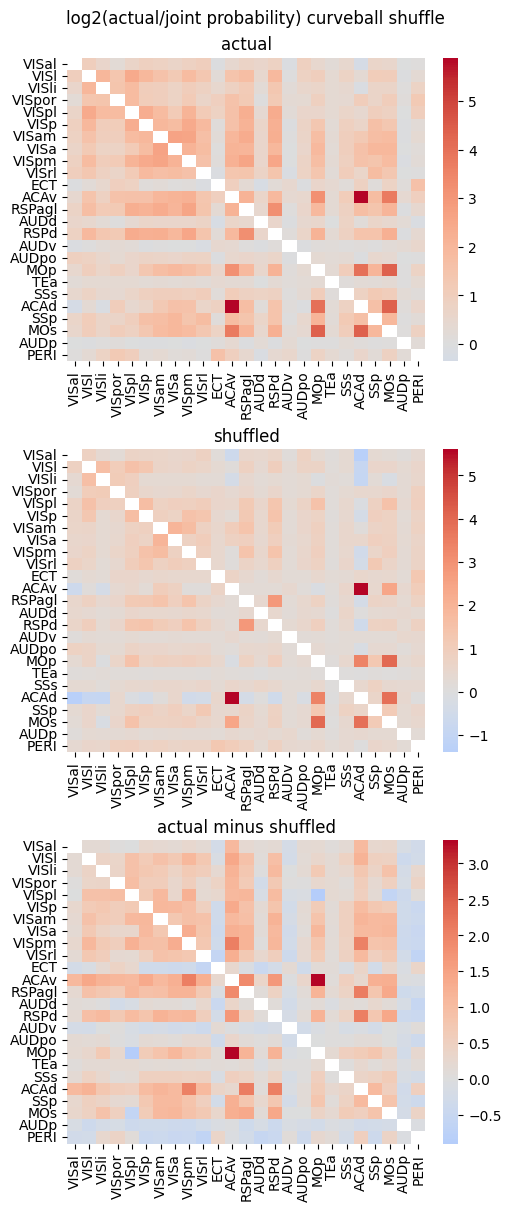

In [16]:
fig, axs = plt.subplots(3, 1, figsize=(5, 12), constrained_layout=True)

for i, title in enumerate(['actual', 'shuffled', 'actual minus shuffled']):
    if i < 2:
        key_to_look = ['homogenous_across_cubelet', 'shuff_cubelet'][i]
        #comp = np.log2(dict_of_co_proj_motifs[key_to_look]/dict_of_co_proj_motifs[f'{key_to_look}_joint'])
        x = dict_of_co_proj_motifs[key_to_look]/dict_of_co_proj_motifs[f'{key_to_look}_joint']
        x.replace(np.nan, 0, inplace=True)
        with np.errstate(divide='ignore', invalid='ignore'):  # Suppress warnings for log(0) or invalid operations
            comp = np.log2(x)
        comp.replace([np.inf, -np.inf], np.nan, inplace=True)
        if key_to_look == 'shuff_cubelet':
            shuff_comp = comp
        else:
            actual_comp = comp
    if i == 2:
        comp = actual_comp - shuff_comp
    sb.heatmap(ax=axs[i], data=comp, cmap='coolwarm', center=0, xticklabels=True, yticklabels=True)
    axs[i].set_title(title)
plt.suptitle('log2(actual/joint probability) curveball shuffle')

Text(0.5, 0.98, 'actual/joint probability normal shuffle')

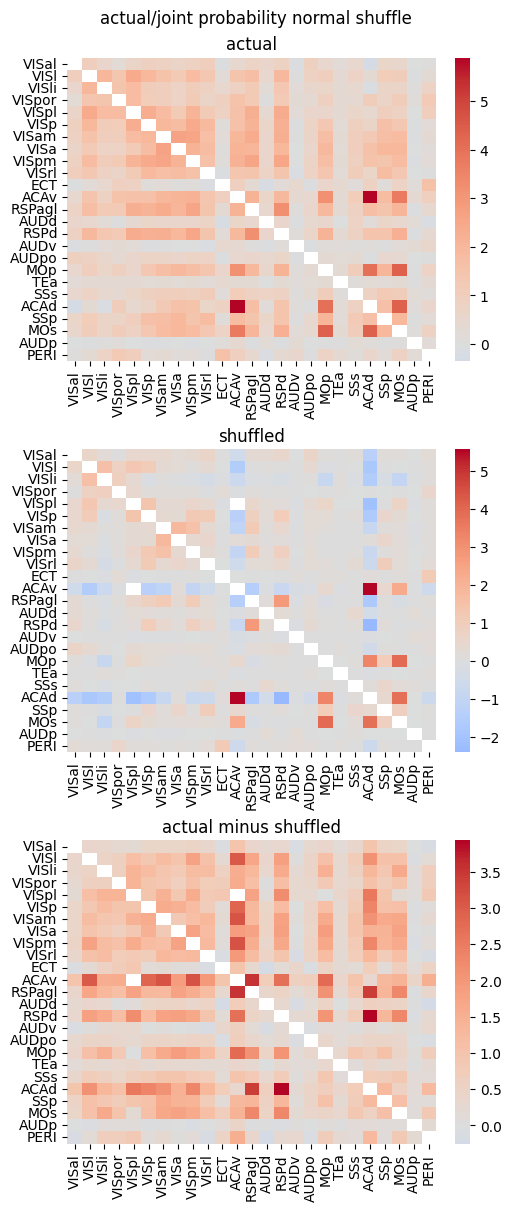

In [18]:
key = 'homogenous_across_cubelet'
all_combined={}
common_cols_cortex = []
for col in common_cols:
    if col not in ['Contra', 'OB']:
        structure = structure_tree.get_structures_by_acronym([col])
        if 315 in structure[0]['structure_id_path']:
            common_cols_cortex.append(col)
combined_matrix = pd.concat([homog_across_cubelet_dict['FIAA45.6a']['actual'][common_cols_cortex], homog_across_cubelet_dict['FIAA45.6d']['actual'][common_cols_cortex], homog_across_cubelet_dict['FIAA55.4d']['actual'][common_cols_cortex]])
cols = ['VISal', 'VISl',  'VISli','VISpor', 'VISpl', 'VISp', 'VISam', 'VISa', 'VISpm', 'VISrl']
#cols = ['VISli','VISpor', 'VISpl', 'VISl', 'VISp', 'VISal', 'VISam', 'VISpm', 'VISa', 'VISrl']
all_combined[key] = combined_matrix
all_combined['shuff_cubelet'] = pd.concat([homog_across_cubelet_dict['FIAA45.6a']['shuffled'][common_cols_cortex], homog_across_cubelet_dict['FIAA45.6d']['shuffled'][common_cols_cortex], homog_across_cubelet_dict['FIAA55.4d']['shuffled'][common_cols_cortex]])
dict_of_co_proj_motifs = {}
for key in all_combined.keys():
    co_proj_motif_actual = pd.DataFrame(columns=cols, index=cols)
    co_proj_motif_joint = pd.DataFrame(columns=cols, index=cols)
    barcodes = all_combined[key].copy()
    for col in common_cols_cortex:
        for col_2 in common_cols_cortex:
            if col == col_2:
                co_proj_motif_actual.loc[col, col_2] = np.nan
                co_proj_motif_joint.loc[col, col_2] = np.nan
            else:
                prob_df = pd.DataFrame()
                prob_df["a"] = barcodes[col].astype(bool)
                prob_df["b"] = barcodes[col_2].astype(bool)
                prob_df["matching"] = prob_df.apply(lambda x: 1 if x['a'] and x['b'] else 0, axis=1)
                probs_actual = prob_df["matching"].sum() / len(barcodes)
                probs_joint = (prob_df["a"].sum() / len(barcodes)) * (prob_df["b"].sum() / len(barcodes))
                co_proj_motif_actual.loc[col, col_2] = probs_actual
                co_proj_motif_joint.loc[col, col_2] = probs_joint
    dict_of_co_proj_motifs[key] = co_proj_motif_actual
    dict_of_co_proj_motifs[f'{key}_joint'] = co_proj_motif_joint
fig, axs = plt.subplots(3, 1, figsize=(5, 12), constrained_layout=True)

for i, title in enumerate(['actual', 'shuffled', 'actual minus shuffled']):
    if i < 2:
        key_to_look = ['homogenous_across_cubelet', 'shuff_cubelet'][i]
        #comp = np.log2(dict_of_co_proj_motifs[key_to_look]/dict_of_co_proj_motifs[f'{key_to_look}_joint'])
        x = dict_of_co_proj_motifs[key_to_look]/dict_of_co_proj_motifs[f'{key_to_look}_joint']
        x.replace(np.nan, 0, inplace=True)
        with np.errstate(divide='ignore', invalid='ignore'):  # Suppress warnings for log(0) or invalid operations
            comp = np.log2(x)
        comp.replace([np.inf, -np.inf], np.nan, inplace=True)
        if key_to_look == 'shuff_cubelet':
            shuff_comp = comp
        else:
            actual_comp = comp
    if i == 2:
        comp = actual_comp - shuff_comp
    sb.heatmap(ax=axs[i], data=comp, cmap='coolwarm', center=0, xticklabels=True, yticklabels=True)
    axs[i].set_title(title)
plt.suptitle('actual/joint probability normal shuffle')


Text(0.5, 0.98, 'log2(actual/joint probability) curve ball shuffle')

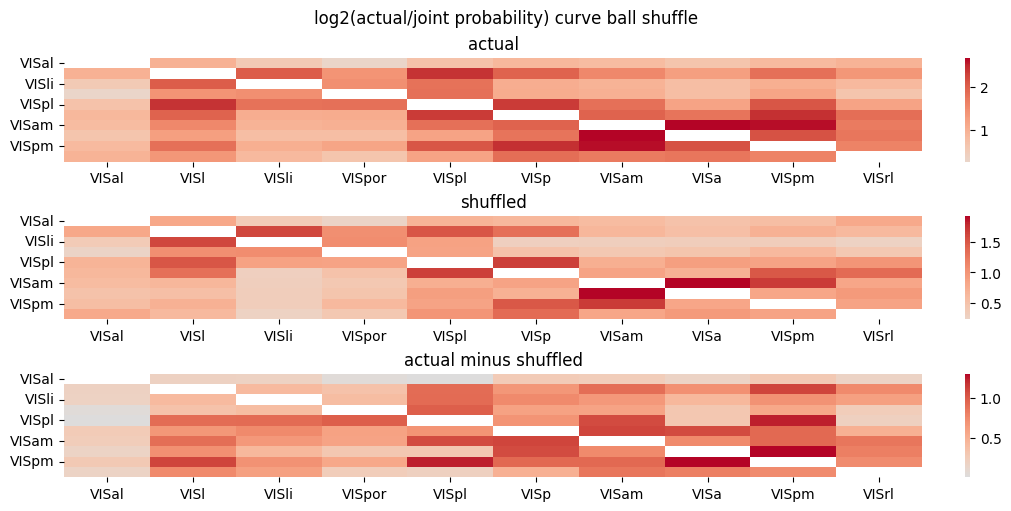

In [7]:
fig, axs = plt.subplots(3, 1, figsize=(10, 5), constrained_layout=True)

for i, title in enumerate(['actual', 'shuffled', 'actual minus shuffled']):
    if i < 2:
        key_to_look = ['homogenous_across_cubelet', 'shuff_cubelet'][i]
        #comp = np.log2(dict_of_co_proj_motifs[key_to_look]/dict_of_co_proj_motifs[f'{key_to_look}_joint'])
        x = dict_of_co_proj_motifs[key_to_look]/dict_of_co_proj_motifs[f'{key_to_look}_joint']
        x.replace(np.nan, 0, inplace=True)
        with np.errstate(divide='ignore', invalid='ignore'):  # Suppress warnings for log(0) or invalid operations
            comp = np.log2(x)
        comp.replace([np.inf, -np.inf], np.nan, inplace=True)
        if key_to_look == 'shuff_cubelet':
            shuff_comp = comp
        else:
            actual_comp = comp
    if i == 2:
        comp = actual_comp - shuff_comp
    sb.heatmap(ax=axs[i], data=comp, cmap='coolwarm', center=0)
    axs[i].set_title(title)
plt.suptitle('log2(actual/joint probability) curve ball shuffle')